##  데이터 처리순서 
1. 비지니스 문제 정의
2. 전처리 & EDA(데이터 이해 과정) : 랭글링, 시각화, 특성 선택 등.
3. 데이터 모델링
4. 비지니스 문제 해결

# 1.문제 정의
##  체코 은행 데이터 셋을 통해 비지니스 문제 해결해보기

 

####  위험고객과 우수고객을 판단하는 예측(Primary)

### 추가적 인사이트 도출
#### 1) 신용카드 마케팅 방법 ?

#### 2) 은행의 자금 흐름이 어떻게 되고 있는가 ?





# 2. 데이터 전처리 & EDA

## 데이터 불러오기

# Data 랭글링  
## 랭글링 :  원자료(raw data)를 또다른 형태로 수작업으로 전환하거나 매핑하는 과정

- account_id로 groupby
- feature engineering
- Join Merge

In [1]:
import pandas as pd

# 데이터셋 4개
loan = pd.read_csv("loan 수정.csv")
trans = pd.read_csv("trans 수정.csv")
disp = pd.read_csv("new_disposition.csv")
client = pd.read_csv("new_client.csv")

In [2]:
# 대출 데이터 정보 
 # -> null값 존재 : operation, k_symbol, bank, account
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   loan_id     682 non-null    int64 
 1   account_id  682 non-null    int64 
 2   date        682 non-null    int64 
 3   amount      682 non-null    int64 
 4   duration    682 non-null    int64 
 5   payments    682 non-null    int64 
 6   status      682 non-null    object
dtypes: int64(6), object(1)
memory usage: 37.4+ KB


In [3]:
# 거래내역 데이터 정보
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   trans_id    1048575 non-null  int64  
 1   account_id  1048575 non-null  int64  
 2   date        1048575 non-null  int64  
 3   type        1048575 non-null  object 
 4   operation   869912 non-null   object 
 5   amount      1048575 non-null  float64
 6   balance     1048575 non-null  float64
 7   k_symbol    569929 non-null   object 
 8   bank        273508 non-null   object 
 9   account     295002 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 80.0+ MB


In [4]:
# 본인 명의 신용카드인지 여부
disp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5369 non-null   int64 
 1   disp_id     5369 non-null   int64 
 2   client_id   5369 non-null   int64 
 3   account_id  5369 non-null   int64 
 4   type        5369 non-null   object
dtypes: int64(4), object(1)
memory usage: 209.9+ KB


In [5]:
# 고객 개인 정보
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    5369 non-null   int64 
 1   client_id     5369 non-null   int64 
 2   birth_number  5369 non-null   int64 
 3   district_id   5369 non-null   int64 
 4   gender        5369 non-null   object
 5   age           5369 non-null   int64 
 6   age_levels    5369 non-null   object
dtypes: int64(5), object(2)
memory usage: 293.7+ KB


# disposition, client 데이터셋
## - Merge 사용

In [6]:
# 공통 key client_id로 merge
client.head(1)

Unnamed: 0  client_id  birth_number  district_id  gender  age age_levels
0           1          1        701213           18  FEMALE   29      ADULT

In [7]:
disp.head(1)

Unnamed: 0  disp_id  client_id  account_id   type
0           1        1          1           1  OWNER

### Merge

In [8]:
new = pd.merge(client,disp,how = 'inner',on='client_id')
new.head(1)

Unnamed: 0_x  client_id  birth_number  district_id  gender  age age_levels  \
0             1          1        701213           18  FEMALE   29      ADULT   

   Unnamed: 0_y  disp_id  account_id   type  
0             1        1           1  OWNER

In [9]:
#본인명의의 카드 내역만 가져오기
new = new[new['type']=='OWNER']
new = new.drop(['Unnamed: 0_x','Unnamed: 0_y','client_id','disp_id','type'],axis=1)
new.head(1)

birth_number  district_id  gender  age age_levels  account_id
0        701213           18  FEMALE   29      ADULT           1

# trans, loan 데이터셋
##  - Feature Engineering, Groupby, Join 사용

In [10]:
trans.head(1)

trans_id  account_id    date    type operation  amount  balance k_symbol  \
0    695247        2378  930101  PRIJEM     VKLAD   700.0    700.0      NaN   

  bank  account  
0  NaN      NaN

In [11]:
loan.head(1)

loan_id  account_id    date  amount  duration  payments status
0     5314        1787  930705   96396        12      8033      B

In [12]:
# 출금(VYDAJ)에는 현금(VYBER), 다른 은행으로 송금(PREVOD NA UCET), 신용카드 인출(VYBER KARTOU)
trans[trans['type'] == 'VYDAJ']['operation'].unique()

array(['VYBER', 'PREVOD NA UCET', 'VYBER KARTOU'], dtype=object)

In [13]:
# 입금(PRIJEM)에는 현금 입금(VKLAD), 다른 은행에서 입금(PREVOD Z UCTU), 알수 없음 
trans[trans['type'] == 'PRIJEM']['operation'].unique()

array(['VKLAD', 'PREVOD Z UCTU', nan], dtype=object)

In [14]:
# bank 변수 :  타은행 송금할 시 은행 이름(큰 의미없다고 판단해 제거)
trans = trans.drop(['bank'],axis=1)

In [15]:
trans.head(3)

trans_id  account_id    date    type operation  amount  balance k_symbol  \
0    695247        2378  930101  PRIJEM     VKLAD   700.0    700.0      NaN   
1    171812         576  930101  PRIJEM     VKLAD   900.0    900.0      NaN   
2    207264         704  930101  PRIJEM     VKLAD  1000.0   1000.0      NaN   

   account  
0      NaN  
1      NaN  
2      NaN

In [16]:
trans['type'].value_counts()
# VYDAJ(입금), PRIJEM(출금), VYBER(현금)

VYDAJ     631895
PRIJEM    400209
VYBER      16471
Name: type, dtype: int64

In [17]:
#총 입금액
pr = trans[trans['type'] == 'PRIJEM']
pr = pd.DataFrame(pr.groupby('account_id')['amount'].sum())
pr.columns =['총 입금액']
pr.head(3)

총 입금액
account_id           
1            194267.9
2           1596896.8
3            172849.4

In [18]:
#총 출금액
vy = trans[trans['type'] == 'VYDAJ']
vy = pd.DataFrame(vy.groupby('account_id')['amount'].sum())
vy.columns = ['총 출금액']
vy.head(3)

총 출금액
account_id           
1            180854.0
2           1336983.8
3            119402.8

In [19]:
#금융 거래횟수
trans_count = pd.DataFrame(trans.groupby('account_id')['trans_id'].count())
trans_count.columns = ['거래 횟수']
trans_count.head()

거래 횟수
account_id       
1             238
2             477
3             115
4             185
5              81

In [20]:
# 잔고가 마이너스였던 횟수
List=[]
for i in trans['balance']:
  if i < 0:
     a = 1 
  else:
     a = 0 
  List.append(a)
trans['minus'] = List
minus = pd.DataFrame(trans.groupby('account_id')['minus'].sum())
minus.columns = ['마이너스 횟수']
minus.head()

마이너스 횟수
account_id         
1                 0
2                 0
3                 0
4                 0
5                 0

In [21]:
# 현재 잔고 
balance = pd.DataFrame(trans.groupby('account_id')['balance'].last())
balance.columns = ['현재 잔고']
balance.head()

현재 잔고
account_id         
1           13413.9
2           42471.3
3           53446.5
4           33585.0
5           28916.2

In [22]:
# k_symbol 원핫인코딩 후 각 거래특성 별 이용횟수 구하기
sym = pd.get_dummies(trans['k_symbol'])
trans = pd.concat([trans,sym],axis=1)

In [23]:
# 마이너스 잔액 이자 지불 횟수
min_inter = pd.DataFrame(trans.groupby('account_id')['SANKC. UROK'].sum())
min_inter.columns =['마이너스 이자']
min_inter.head()

마이너스 이자
account_id         
1                 0
2                 0
3                 0
4                 0
5                 0

In [24]:
# 대출 결제 횟수 
uver = pd.DataFrame(trans.groupby('account_id')['UVER'].sum())
uver.columns = ['대출 결제']
uver.head()

대출 결제
account_id       
1               0
2              24
3               0
4               0
5               0

In [25]:
# 대출 결제 횟수 
urok= pd.DataFrame(trans.groupby('account_id')['UROK'].sum())
urok.columns = ['이자 지급 횟수']
urok.head()

이자 지급 횟수
account_id          
1                 44
2                 69
3                 17
4                 29
5                 14

In [26]:
# 대출 결제 횟수 
poj = pd.DataFrame(trans.groupby('account_id')['POJISTNE'].sum())
poj.columns = ['보험금 지급 횟수']
poj.head()

보험금 지급 횟수
account_id           
1                   0
2                   0
3                  13
4                   0
5                   0

In [27]:
# 대출 결제 횟수 
doc = pd.DataFrame(trans.groupby('account_id')['DUCHOD'].sum())
doc.columns = ['노령 연금']
doc.head()

노령 연금
account_id       
1               0
2               0
3               0
4              34
5              19

In [28]:
trans.head()

trans_id  account_id    date    type operation  amount  balance k_symbol  \
0    695247        2378  930101  PRIJEM     VKLAD   700.0    700.0      NaN   
1    171812         576  930101  PRIJEM     VKLAD   900.0    900.0      NaN   
2    207264         704  930101  PRIJEM     VKLAD  1000.0   1000.0      NaN   
3   1117247        3818  930101  PRIJEM     VKLAD   600.0    600.0      NaN   
4    579373        1972  930102  PRIJEM     VKLAD   400.0    400.0      NaN   

   account  minus     DUCHOD  POJISTNE  SANKC. UROK  SIPO  SLUZBY  UROK  UVER  
0      NaN      0  0       0         0            0     0       0     0     0  
1      NaN      0  0       0         0            0     0       0     0     0  
2      NaN      0  0       0         0            0     0       0     0     0  
3      NaN      0  0       0         0            0     0       0     0     0  
4      NaN      0  0       0         0            0     0       0     0     0

In [29]:
# 사용 후 drop
trans = trans.drop(['DUCHOD','POJISTNE','SANKC. UROK','SIPO','SLUZBY','UROK','UVER'],axis=1)

In [30]:
operation = pd.get_dummies(trans['operation'])
trans = pd.concat([trans,operation],axis=1)
trans = trans.drop(['operation'],axis=1)

In [31]:
trans.head()

trans_id  account_id    date    type  amount  balance k_symbol  account  \
0    695247        2378  930101  PRIJEM   700.0    700.0      NaN      NaN   
1    171812         576  930101  PRIJEM   900.0    900.0      NaN      NaN   
2    207264         704  930101  PRIJEM  1000.0   1000.0      NaN      NaN   
3   1117247        3818  930101  PRIJEM   600.0    600.0      NaN      NaN   
4    579373        1972  930102  PRIJEM   400.0    400.0      NaN      NaN   

   minus     PREVOD NA UCET  PREVOD Z UCTU  VKLAD  VYBER  VYBER KARTOU  
0      0  0               0              0      1      0             0  
1      0  0               0              0      1      0             0  
2      0  0               0              0      1      0             0  
3      0  0               0              0      1      0             0  
4      0  0               0              0      1      0             0

In [32]:
import warnings
 
warnings.filterwarnings("ignore")
# 다른 은행으로 출금, 다른 은행에서 입금, 현금 입금, , 현금출금, 신용카드 출금의 거래 횟수 
type = pd.DataFrame(trans.groupby('account_id')['PREVOD NA UCET','PREVOD Z UCTU','VKLAD','VYBER','VYBER KARTOU'].sum())
type.columns = ['타은행 출금', '타은행 입금', '현금입금', '현금출금', '신용카드 출금']
type

타은행 출금  타은행 입금  현금입금   현금출금  신용카드 출금
account_id                                      
1             40.0    45.0  12.0   97.0      0.0
2             89.0    70.0  12.0  237.0      0.0
3             39.0     0.0  28.0   31.0      0.0
4             59.0    34.0   1.0   62.0      0.0
5             14.0    19.0   1.0   33.0      0.0
...            ...     ...   ...    ...      ...
11333          0.0     0.0  78.0  184.0      0.0
11349         77.0    43.0   5.0  135.0      0.0
11359        104.0    51.0   2.0  147.0     22.0
11362        160.0     0.0  43.0  103.0      0.0
11382          0.0    40.0   1.0  131.0      0.0

[4500 rows x 5 columns]

In [33]:
date = pd.DataFrame(trans.groupby('account_id')['date'].apply(sorted))

# 리스트의 [0]는 첫 이용일, 리스트의 [-1]은 마지막 이용일
first =[]
end = []
for i in date['date']:
  a = i[0]
  b = i[-1]
  first.append(a)
  end.append(b)

In [34]:
# 새로운 date 데이터프레임 형성
first_date = pd.DataFrame(first,columns=['first_date'], index=date.index)
end_date = pd.DataFrame(end,columns=['end_date'], index=date.index)
date = first_date.join(end_date)

date['end_date'] = pd.to_datetime(date['end_date'].astype(str),format='%y%m%d')
date['first_date'] = pd.to_datetime(date['first_date'].astype(str),format='%y%m%d')
date['period'] = date['end_date']-date['first_date']
date['period'] = date['period'].dt.days

date['today'] = pd.to_datetime(981219,format='%y%m%d')
date['unused'] = (date['today'] - date['end_date']).dt.days

#  이용한 기간, 이용하지 않은 기간 추출
date=date.drop(['first_date','end_date','today'],axis=1)
date.columns=['이용기간', '이용하지 않은 기간']
date.head(1)

이용기간  이용하지 않은 기간
account_id                  
1           1360           6

In [35]:
# feature engineering을 통한 새로운 df 형성

new_df = pr.join([vy,minus,trans_count,balance,min_inter,uver,poj,urok,doc,type,date])
new_df

총 입금액      총 출금액  마이너스 횟수  거래 횟수    현재 잔고  마이너스 이자  대출 결제  \
account_id                                                                  
1            194267.9   180854.0        0    238  13413.9        0      0   
2           1596896.8  1336983.8        0    477  42471.3        0     24   
3            172849.4   119402.8        0    115  53446.5        0      0   
4            192210.3   158625.4        0    185  33585.0        0      0   
5             97362.9    68446.4        0     81  28916.2        0      0   
...               ...        ...      ...    ...      ...      ...    ...   
11333       1676692.6  1211974.9       11    365  63654.0       13      0   
11349       1995489.2  1728418.0        0    302  37691.9        0     38   
11359       1511358.6  1403011.2        0    376  78817.8        0     12   
11362        684107.9   645739.8        0    343  38367.8        0     24   
11382       1351806.1  1052031.4        6    250  87362.4        8      0   

            보험금 지급 횟수  이자 지급 횟수  노령 연금  타은행 출금  타은행 입금  현금입금   현금출금  신용카드 출금  \
account_id                                                                     
1                   0        44      0    40.0    45.0  12.0   97.0      0.0   
2                   0        69      0    89.0    70.0  12.0  237.0      0.0   
3                  13        17      0    39.0     0.0  28.0   31.0      0.0   
4                   0        29     34    59.0    34.0   1.0   62.0      0.0   
5                   0        14     19    14.0    19.0   1.0   33.0      0.0   
...               ...       ...    ...     ...     ...   ...    ...      ...   
11333               0       103      0     0.0     0.0  78.0  184.0      0.0   
11349               0        42      0    77.0    43.0   5.0  135.0      0.0   
11359               0        50      0   104.0    51.0   2.0  147.0     22.0   
11362              34        37      0   160.0     0.0  43.0  103.0      0.0   
11382               0        78      0     0.0    40.0   1.0  131.0      0.0   

            이용기간  이용하지 않은 기간  
account_id                    
1           1360           6  
2           2120           2  
3            522           8  
4           1026           6  
5            567           1  
...          ...         ...  
11333       1664           4  
11349       1302           1  
11359       1535           5  
11362       1162           0  
11382       1208           9  

[4500 rows x 17 columns]

In [36]:
new.index = new.account_id

In [37]:
new = new.drop(['account_id'],axis=1)

In [38]:
# 계좌 owner 고객 정보 join
new= new.join(new_df)
new = new.drop(['birth_number','district_id','age'], axis=1)

In [39]:
new.head(2)

gender   age_levels      총 입금액      총 출금액  마이너스 횟수  거래 횟수  \
account_id                                                              
1           FEMALE        ADULT   194267.9   180854.0        0    238   
2             MALE  MIDDLE AGED  1596896.8  1336983.8        0    477   

              현재 잔고  마이너스 이자  대출 결제  보험금 지급 횟수  이자 지급 횟수  노령 연금  타은행 출금  \
account_id                                                                
1           13413.9        0      0          0        44      0    40.0   
2           42471.3        0     24          0        69      0    89.0   

            타은행 입금  현금입금   현금출금  신용카드 출금  이용기간  이용하지 않은 기간  
account_id                                                  
1             45.0  12.0   97.0      0.0  1360           6  
2             70.0  12.0  237.0      0.0  2120           2

In [40]:
loan.index = loan.account_id
loan = loan.drop(['account_id','date','loan_id','duration','payments'],axis=1)
loan.columns = ['대출 금액','대출 상태']
loan.head()

대출 금액 대출 상태
account_id              
1787         96396     B
1801        165960     A
9188        127080     A
1843        105804     A
11013       274740     A

In [41]:
final = new.join(loan)
final.head()

gender   age_levels      총 입금액      총 출금액  마이너스 횟수  거래 횟수  \
account_id                                                              
1           FEMALE        ADULT   194267.9   180854.0        0    238   
2             MALE  MIDDLE AGED  1596896.8  1336983.8        0    477   
3             MALE  MIDDLE AGED   172849.4   119402.8        0    115   
4             MALE       SENIOR   192210.3   158625.4        0    185   
5             MALE       SENIOR    97362.9    68446.4        0     81   

              현재 잔고  마이너스 이자  대출 결제  보험금 지급 횟수  ...  노령 연금  타은행 출금  타은행 입금  \
account_id                                      ...                          
1           13413.9        0      0          0  ...      0    40.0    45.0   
2           42471.3        0     24          0  ...      0    89.0    70.0   
3           53446.5        0      0         13  ...      0    39.0     0.0   
4           33585.0        0      0          0  ...     34    59.0    34.0   
5           28916.2        0      0          0  ...     19    14.0    19.0   

            현금입금   현금출금  신용카드 출금  이용기간  이용하지 않은 기간    대출 금액  대출 상태  
account_id                                                          
1           12.0   97.0      0.0  1360           6      NaN    NaN  
2           12.0  237.0      0.0  2120           2  80952.0      A  
3           28.0   31.0      0.0   522           8      NaN    NaN  
4            1.0   62.0      0.0  1026           6      NaN    NaN  
5            1.0   33.0      0.0   567           1      NaN    NaN  

[5 rows x 21 columns]


## - 결측치 처리

In [ ]:
!pip install missingno

In [44]:
# 한글 깨짐 설정
import matplotlib.pyplot
import matplotlib as mpl

mpl.pyplot.rc('font', family='NanumGothic')
mpl.rcParams['axes.unicode_minus']=False

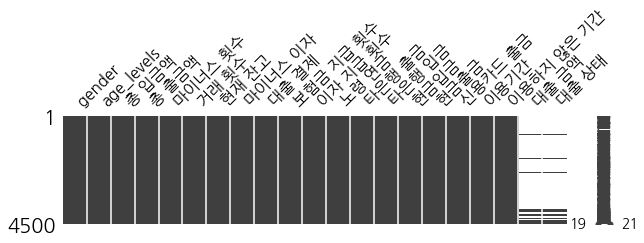

In [45]:
# 결측치 확인
import missingno as msno
msno.matrix(final, figsize=(10,2))

In [46]:
final.isnull().sum()

gender           0
age_levels       0
총 입금액            0
총 출금액            0
마이너스 횟수          0
거래 횟수            0
현재 잔고            0
마이너스 이자          0
대출 결제            0
보험금 지급 횟수        0
이자 지급 횟수         0
노령 연금            0
타은행 출금           0
타은행 입금           0
현금입금             0
현금출금             0
신용카드 출금          0
이용기간             0
이용하지 않은 기간       0
대출 금액         3818
대출 상태         3818
dtype: int64

In [47]:
# 대출 금액이 없어서 NaN 값이므로 0으로 대체
final.loc[final['대출 금액'].isnull(),'대출 금액'] = 0

In [48]:
# 대출 내역이 없어 대출 상태를 알 수 없으므로 동일하게 status 'E' 표시
final.loc[final['대출 상태'].isnull(),'대출 상태'] = 'E'

## - 이상치 반영하여 표준화 : Robust Scaler 사용
 
 - Robust Scaler 는 이상치를 반영해 데이터 표준화 가능 
 - IQR을 이용해 이상치를 제거 했을 경우 너무 많은 데이터가 지워지므로 생략

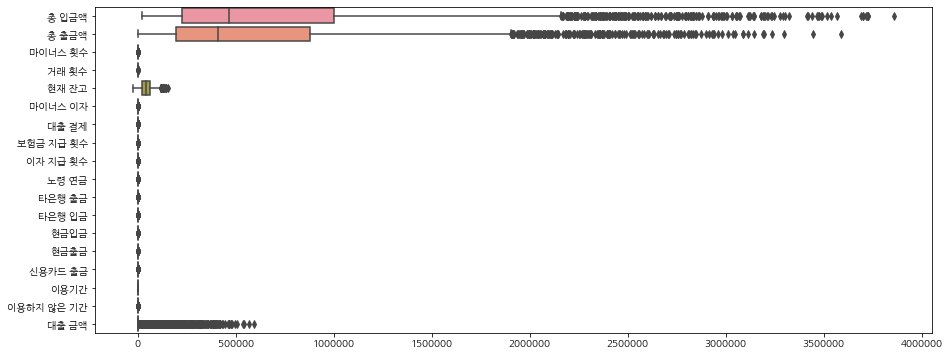

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(15,6))
sns.boxplot(data=final,orient='h', ax=ax)

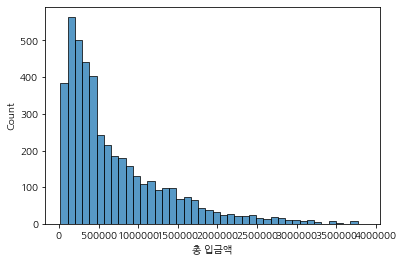

In [50]:
sns.histplot(final['총 입금액'])

In [51]:
final=final.reset_index()
final_copy = final
final= final.drop(['account_id'],axis=1)

In [52]:
num_final = final.loc[:,'총 입금액':'대출 금액']

In [53]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
final.loc[:,'총 입금액':'대출 금액'] = pd.DataFrame(scaler.fit_transform(num_final), columns=num_final.columns)

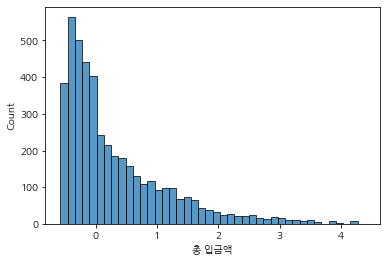

In [54]:
b = sns.histplot(final['총 입금액'])

## 3) 범주형 데이터 인코딩
-  "gender" 변수 : one_hot encoding (get_dummies 사용)  => 남녀 구분은 등급이 없으므로 one_hot 인코딩 필요
- "age_levels"와 "대출 상태" 변수: label encoding

In [55]:
final[['age_levels','대출 상태']]

age_levels 대출 상태
0           ADULT     E
1     MIDDLE AGED     A
2     MIDDLE AGED     E
3          SENIOR     E
4          SENIOR     E
...           ...   ...
4495  MIDDLE AGED     E
4496  MIDDLE AGED     C
4497        ADULT     A
4498  MIDDLE AGED     A
4499  MIDDLE AGED     E

[4500 rows x 2 columns]

In [56]:
gender = pd.get_dummies(final['gender'])
final = pd.concat([final,gender],axis=1)
final = final.drop(['gender'],axis=1)

In [57]:
def age_encoder():
    final.loc[final['age_levels']=='SENIOR','age_levels'] = 4
    final.loc[final['age_levels']=='MIDDLE AGED','age_levels'] = 3
    final.loc[final['age_levels']=='ADULT','age_levels'] = 2
    final.loc[final['age_levels']=='YOUTH','age_levels'] = 1 
age_encoder()    

In [58]:
final['age_levels'] = final['age_levels'].astype(int)

In [59]:
#  A, C, E, D, B =>  5, 4, 3, 2, 1 (신용도)
def loan_encoder():
    final.loc[final['대출 상태']=='A','대출 상태'] = 5
    final.loc[final['대출 상태']=='C','대출 상태'] = 4
    final.loc[final['대출 상태']=='E','대출 상태'] = 3
    final.loc[final['대출 상태']=='D','대출 상태'] = 2
    final.loc[final['대출 상태']=='B','대출 상태'] = 1
loan_encoder()   

In [60]:
final['대출 상태'] = final['대출 상태'].astype(int)

#### ------------- 전처리 완료 -------------

# 타겟 데이터 라벨링


In [61]:
final['고객 등급'] = 0

## TARGET : 1 (우수고객)

1. 
대출 상태가 A(0)인 경우

2. 
(현재 잔고 상위 25%) & (마이너스 횟수  = 0) & (마이너스 이자 = 0) & (이용기간 상위 50%) & (이용하지 않은 기간 하위 25%) 인 경우


## 스케일링을 거쳤으므로 타겟데이터를 다시 정의해야함 (퍼센트로 정의하는게 나을 듯 )
## 타겟 데이터 라벨링 하는 법 

In [62]:
# 대출 거래시 상태 A -- 신용카드 고객 중 대출 거래는 일부 고객만 함
final.loc[final['대출 상태'] == 5,'고객 등급'] = 1

In [63]:
import numpy as np


# 상위 25% 데이터 추출
def percent75(data,col):
  up = np.percentile(data[col], 0.75)
  return up

# 50% 데이터 추출
def percent50(data,col):
  up = np.percentile(data[col], 0.50)
  return up

# 하위 25% 데이터 추출
def percent25(data,col):
  up = np.percentile(data[col], 0.25)
  return up



# 은행마다 신용평가 모델이 다르며 자체적으로 기준을 두고 모델을 만듬 
# 내가 적당하다고 생각하는 기준으로 정함
# 현재 상위 25% & 마이너스 이자 0 & 이용기간 2년이상 & 마지막 거래가 한달 이내 
final.loc[(final['현재 잔고'] >= percent75(final,'현재 잔고'))&(final['마이너스 이자'] == 0)&(final['이용기간'] >= percent50(final,'이용기간'))& (final['이용하지 않은 기간'] <= percent25(final,'이용하지 않은 기간')),'고객 등급'] = 1

In [64]:
final['고객 등급'].value_counts()

0    4274
1     226
Name: 고객 등급, dtype: int64

## TARGET : C(위험고객)

1. 대출 상태가 B(1)인 경우
2. (잔금 하위 25%) & (마이너스 이자 지불 1회 이상) & (마이너스 잔고 횟수 1회 이상) 인 경우

In [65]:
# 대출 거래 시 상태 B -- 계약이 완료됐으나 미납 중인 고객 (위험 확률 크다고 판단)
final.loc[final['대출 상태'] == 1, '고객 등급'] = 3


In [66]:
# 잔금 하위 25% & (마이너스 잔고 이자지불 횟수 1번이상)
final.loc[(final['현재 잔고'] < percent25(final,'현재 잔고'))& ((final['마이너스 이자'] > 0)|(final['마이너스 횟수'] > 0)),'고객 등급'] = 3

## TARGET :B(일반고객)

- 우수고객(1), 위험고객(3) 이외는 일반 고객(2)

In [67]:
# 그 이외는 일반고객
final.loc[final['고객 등급'] == 0,'고객 등급'] = 2

In [68]:
import seaborn as sns
target = final['고객 등급']
target.value_counts()
 # 불균형한 타겟데이터

2    4231
1     226
3      43
Name: 고객 등급, dtype: int64

## 타겟 데이터 분포 불균형 

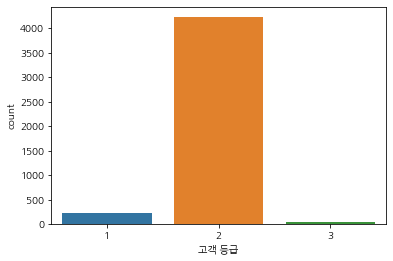

In [69]:
sns.countplot(final['고객 등급'])

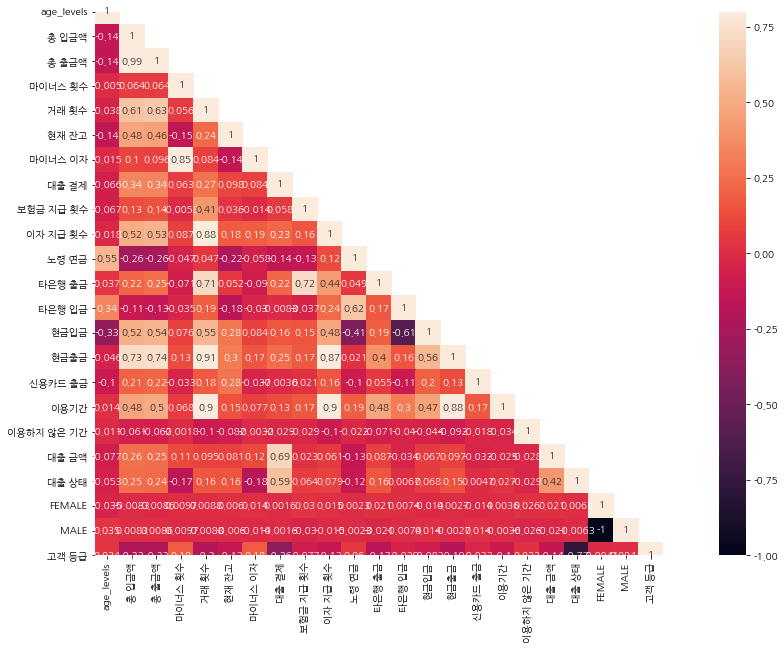

In [72]:
import numpy as np
corrMatt = final.corr()
mask = np.array(final.corr())
mask[np.tril_indices_from(mask)]=False

fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True, annot=True)

# 다중공선성 문제 해결

In [73]:
final[:-1].shape[1]

23

In [74]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(final[:-1].values, i) 
                     for i in range(final[:-1].shape[1])]
vif['Feature'] = final[:-1].columns
vif.sort_values(by='VIF', ascending=True)

VIF     Feature
17    1.071367  이용하지 않은 기간
0     1.529387  age_levels
5     1.604188       현재 잔고
18    2.203592       대출 금액
10    2.392150       노령 연금
8     2.655187   보험금 지급 횟수
22    2.811906       고객 등급
7     2.821870       대출 결제
19    3.776785       대출 상태
3     4.142692     마이너스 횟수
6     4.626445     마이너스 이자
16   12.811141        이용기간
1   115.369525       총 입금액
2   115.559640       총 출금액
4          inf       거래 횟수
9          inf    이자 지급 횟수
21         inf        MALE
12         inf      타은행 입금
13         inf        현금입금
14         inf        현금출금
15         inf     신용카드 출금
20         inf      FEMALE
11         inf      타은행 출금

In [75]:
final = final.drop(['총 입금액' ,'이용기간'],axis=1)

In [76]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(final[:-1].values, i) 
                     for i in range(final[:-1].shape[1])]
vif['Feature'] = final[:-1].columns
vif.sort_values(by='VIF', ascending=True)

VIF     Feature
15  1.019819  이용하지 않은 기간
4   1.459076       현재 잔고
0   1.524205  age_levels
16  2.196851       대출 금액
9   2.319468       노령 연금
7   2.507542   보험금 지급 횟수
6   2.771973       대출 결제
20  2.808869       고객 등급
1   3.538167       총 출금액
17  3.749790       대출 상태
2   3.988340     마이너스 횟수
5   4.302310     마이너스 이자
8        inf    이자 지급 횟수
3        inf       거래 횟수
19       inf        MALE
11       inf      타은행 입금
12       inf        현금입금
13       inf        현금출금
14       inf     신용카드 출금
18       inf      FEMALE
10       inf      타은행 출금

# Data Leakage 방지 

In [77]:
#leakage방지를 위해 grade 생성시 사용한 특성 제거(비금융적 정보로 우수고객 예측하기) 
final = final.drop(["현재 잔고", "마이너스 횟수", "마이너스 이자","이용하지 않은 기간","대출 상태"],axis=1)

# 데이터 나누기 : feature와 target

In [78]:
final.columns

Index(['age_levels', '총 출금액', '거래 횟수', '대출 결제', '보험금 지급 횟수', '이자 지급 횟수',
       '노령 연금', '타은행 출금', '타은행 입금', '현금입금', '현금출금', '신용카드 출금', '대출 금액',
       'FEMALE', 'MALE', '고객 등급'],
      dtype='object')

In [79]:
# 은행의 거래 금액 큰 고객 가려내기 고객 등급 매기기 
target = '고객 등급'

#leakage방지를 위해 grade 생성시 사용한 특성 제거(비금융적 정보로 우수고객 예측하기) 


train_y = final[target]
train_X = final.drop(['고객 등급'],axis=1) 

In [80]:
train_y2 = final[target]
train_X2 =  final.drop(['고객 등급'],axis=1) 

In [81]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(train_X,train_y, train_size=0.8,random_state=24)

# baseline 모델

In [82]:
train_y.value_counts()

2    3375
1     187
3      38
Name: 고객 등급, dtype: int64

In [83]:
base_y = pd.Series([2]*len(train_y))

In [84]:
train_y = train_y.astype(int)

In [86]:
import warnings
 
warnings.filterwarnings("ignore")
# 데이터가 불균형하기 때문에 f1_score로 정확도 측정
from sklearn.metrics import classification_report
print(classification_report(train_y, base_y))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00       187
           2       0.94      1.00      0.97      3375
           3       0.00      0.00      0.00        38

    accuracy                           0.94      3600
   macro avg       0.31      0.33      0.32      3600
weighted avg       0.88      0.94      0.91      3600



# 모델 생성

# RandomForest, Logistic, XGBOOST 모델

In [ ]:
!pip install imblearn
!pip install xgboost

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
warnings.filterwarnings("ignore")


# model1
model1 = RandomForestClassifier(max_depth=20, max_features= 0.8, n_estimators= 300)
model1.fit(train_X, train_y)

#model2
model2 =  LogisticRegression()
model2.fit(train_X, train_y)

#model3
model3 = XGBClassifier(xgbclassifier__learning_rate= 0.2, xgbclassifier__max_depth= 3,xgbclassifier__min_child_weight= 4,xgbclassifier__n_estimators= 318,xgbclassifier__subsample= 1)
model3.fit(train_X, train_y)



# 추가_pipline으로 모델 생성 코드

In [89]:
import numpy as np
from sklearn.pipeline import make_pipeline,Pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import cross_val_score

# gender 특성은 onehot , age_levels는 나이에 따른 level이라고 생각해 ordinal로 인코딩 
# pipe =  Pipeline([
#         ('preprocessing', make_pipeline(OneHotEncoder(cols=['gender']),OrdinalEncoder(cols=['age_levels']), RobustScaler())),
#    ('rf',RandomForestClassifier(max_depth=20, max_features= 0.8009300134244958, n_estimators= 313))
# ])



# 성능측정: Classification_report, Cross validation
 - 실제 고객 중 위험 고객을 발견하는 것이 중요하므로 고객 등급 분류 3의 재현율을 봐야함


In [90]:
pred_y1= model1.predict(test_X)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y1))
# 실제 중에 위험고객 0.2% 맞춤 

              precision    recall  f1-score   support

           1       0.71      0.82      0.76        39
           2       0.99      0.98      0.99       856
           3       0.25      0.20      0.22         5

    accuracy                           0.97       900
   macro avg       0.65      0.67      0.66       900
weighted avg       0.97      0.97      0.97       900



In [91]:
scores = cross_val_score(model1, train_X2,train_y2, cv=10, 
                         scoring='f1_macro')
scores.mean()

0.6867586721126047

In [92]:
warnings.filterwarnings("ignore")
pred_y2= model2.predict(test_X)
print(classification_report(test_y, pred_y2))
# 실제 중에 위험고객 한 명도 못 맞춤

              precision    recall  f1-score   support

           1       0.29      0.15      0.20        39
           2       0.96      0.98      0.97       856
           3       0.00      0.00      0.00         5

    accuracy                           0.94       900
   macro avg       0.41      0.38      0.39       900
weighted avg       0.92      0.94      0.93       900



In [93]:
warnings.filterwarnings("ignore")
scores = cross_val_score(model2, train_X2,train_y2, cv=10, 
                         scoring='f1_macro')


In [94]:
scores.mean()

0.40501726517120434

In [95]:
pred_y3= model3.predict(test_X)
print(classification_report(test_y, pred_y3))
# 실제 중에 위험고객 0.8% 맞춤 

              precision    recall  f1-score   support

           1       0.82      0.85      0.84        39
           2       0.99      0.99      0.99       856
           3       0.25      0.20      0.22         5

    accuracy                           0.98       900
   macro avg       0.69      0.68      0.68       900
weighted avg       0.98      0.98      0.98       900



In [ ]:
warnings.filterwarnings("ignore")
scores = cross_val_score(model3, train_X2,train_y2, cv=10, 
                         scoring='f1_macro')

In [97]:
scores.mean()

0.6659023980931734

# 오버샘플링 :SMOTE

In [98]:
# 오버샘플링해서 성능 측정할 데이터
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_over,y_train_over = smote.fit_resample(train_X,train_y)

In [99]:
y_train_over.value_counts()

2    3375
1    3375
3    3375
Name: 고객 등급, dtype: int64

In [ ]:
warnings.filterwarnings("ignore")
# model1
over_model1 = RandomForestClassifier(max_depth=20, max_features= 0.8, n_estimators= 300)
over_model1.fit(X_train_over,y_train_over)

#model2
over_model2 =  LogisticRegression()
over_model2.fit(X_train_over, y_train_over)

#model3
over_model3 = XGBClassifier(learning_rate= 0.2, max_depth= 3,min_child_weight= 4,n_estimators= 318,subsample= 1)
over_model3.fit(X_train_over,y_train_over)

In [102]:
over_pred_y1= over_model1.predict(test_X)
print(classification_report(test_y,over_pred_y1))
# 실제 중에 위험고객 0.8% 맞춤 

              precision    recall  f1-score   support

           1       0.52      0.85      0.65        39
           2       0.99      0.95      0.97       856
           3       0.12      0.40      0.18         5

    accuracy                           0.94       900
   macro avg       0.54      0.73      0.60       900
weighted avg       0.96      0.94      0.95       900



In [103]:
warnings.filterwarnings("ignore")
scores = cross_val_score(over_model1, train_X2,train_y2, cv=10, 
                         scoring='f1_macro')
scores.mean()

0.6904823988472323

In [104]:
over_pred_y2= over_model2.predict(test_X)
print(classification_report(test_y, over_pred_y2))
# 실제 중에 위험고객 0.8% 맞춤 

              precision    recall  f1-score   support

           1       0.19      0.72      0.30        39
           2       0.99      0.79      0.88       856
           3       0.03      0.40      0.05         5

    accuracy                           0.78       900
   macro avg       0.40      0.64      0.41       900
weighted avg       0.95      0.78      0.85       900



In [105]:
warnings.filterwarnings("ignore")
scores = cross_val_score(over_model2, train_X2,train_y2, cv=10, 
                         scoring='f1_macro')
scores.mean()

0.40501726517120434

In [106]:
over_pred_y3= over_model3.predict(test_X)
print(classification_report(test_y, over_pred_y3))
# 실제 중에 위험고객 0.8% 맞춤 

              precision    recall  f1-score   support

           1       0.66      0.79      0.72        39
           2       0.99      0.96      0.98       856
           3       0.11      0.40      0.17         5

    accuracy                           0.95       900
   macro avg       0.59      0.72      0.62       900
weighted avg       0.97      0.95      0.96       900



In [ ]:
warnings.filterwarnings("ignore")
scores = cross_val_score(over_model3, train_X2,train_y2, cv=10, 
                         scoring='f1_macro')


In [108]:
scores.mean()

0.6757745231282849

# 추가_ 오버샘플링 : ADASYN

In [109]:
%%capture

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='logisitcregressor')
# 데이터 불균형으로 인한 과적합으로 언더샘플링 실행한 Train 데이터
from imblearn.over_sampling import  ADASYN
sam =  ADASYN(random_state=42)
x_sam,y_sam = sam.fit_resample(train_X,train_y)

In [110]:
# model1
over2_model1 = RandomForestClassifier(max_depth=20, max_features= 0.8, n_estimators= 300)
over2_model1.fit(x_sam,y_sam )

#model2
over2_model2 =  LogisticRegression()
over2_model2.fit(x_sam,y_sam )

#model3
over2_model3 = XGBClassifier(learning_rate= 0.2, max_depth= 3,min_child_weight= 4,n_estimators= 318,subsample= 1)
over2_model3.fit(x_sam,y_sam )

[12:59:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=3, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=318, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [111]:
over2_pred_y1= over2_model1.predict(test_X)
print(classification_report(test_y,over2_pred_y1))

              precision    recall  f1-score   support

           1       0.52      0.87      0.65        39
           2       0.99      0.95      0.97       856
           3       0.14      0.40      0.21         5

    accuracy                           0.94       900
   macro avg       0.55      0.74      0.61       900
weighted avg       0.96      0.94      0.95       900



In [112]:
over2_pred_y2= over2_model2.predict(test_X)
print(classification_report(test_y,over2_pred_y2))

              precision    recall  f1-score   support

           1       0.19      0.74      0.31        39
           2       0.99      0.79      0.88       856
           3       0.03      0.40      0.05         5

    accuracy                           0.79       900
   macro avg       0.41      0.64      0.41       900
weighted avg       0.95      0.79      0.85       900



In [113]:
over2_pred_y3= over2_model3.predict(test_X)
print(classification_report(test_y,over2_pred_y3))
# smote 방식과 큰 차이 없음

              precision    recall  f1-score   support

           1       0.59      0.82      0.69        39
           2       0.99      0.96      0.97       856
           3       0.11      0.40      0.17         5

    accuracy                           0.95       900
   macro avg       0.56      0.73      0.61       900
weighted avg       0.97      0.95      0.96       900



# 랜덤포레스트(모델1)

## - 하이퍼파리미터 튜닝 : 랜덤 서치 CV

In [118]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
dists = {
    'n_estimators': randint(50,500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1) 
}

##  파라미터 튜닝 : 오버샘플링(SMOTE)된 데이터

In [480]:
clf = RandomizedSearchCV(
    model1, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='f1_macro',  
    verbose=1,
    n_jobs=-1

)
clf.fit(X_train_over, y_train_over)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(max_depth=20,
                                                    max_features=0.8,
                                                    n_estimators=300),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002329B603640>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000232921EEBE0>},
                   scoring='f1_macro', verbose=1)

In [481]:
best_model1= clf.best_estimator_.fit(X_train_over, y_train_over)       
best_pred_y1= best_model1.predict(test_X)
print(classification_report(test_y, best_pred_y1))

              precision    recall  f1-score   support

           1       0.51      0.87      0.64        39
           2       0.99      0.95      0.97       856
           3       0.19      0.60      0.29         5

    accuracy                           0.94       900
   macro avg       0.56      0.81      0.63       900
weighted avg       0.97      0.94      0.95       900



In [482]:
warnings.filterwarnings("ignore")
scores = cross_val_score(clf.best_estimator_, train_X2,train_y2, cv=10, 
                         scoring='f1_macro')
scores.mean()

0.6358027918870427

# XGBoost(모델3) 

## - 하이퍼파리미터 튜닝 : 랜덤 서치 CV

In [119]:
dists =  {'xgbclassifier__n_estimators': randint(150, 1000),
              'xgbclassifier__learning_rate':uniform(0.01, 0.6),
              'xgbclassifier__subsample': uniform(0.3, 0.9),
              'xgbclassifier__max_depth': [3, 4, 5, 6, 7, 8, 9],
              'xgbclassifier__min_child_weight': [1, 2, 3, 4]
             }

##  파라미터 튜닝 : 오버샘플링(SMOTE)된 데이터

In [ ]:
warnings.filterwarnings("ignore")
clf2 = RandomizedSearchCV(
    model3, 
    param_distributions =dists, 
    n_iter=50, 
    cv=3, 
    scoring='f1_macro',  
    verbose=1
)
clf2.fit(X_train_over, y_train_over)

In [ ]:
best_model2= clf2.best_estimator_.fit(X_train_over, y_train_over)   
best_pred_y2= best_model2.predict(test_X)

In [124]:
print(classification_report(test_y, best_pred_y2))

              precision    recall  f1-score   support

           1       0.59      0.85      0.69        39
           2       0.99      0.96      0.98       856
           3       0.15      0.40      0.22         5

    accuracy                           0.95       900
   macro avg       0.58      0.74      0.63       900
weighted avg       0.97      0.95      0.96       900



In [ ]:
warnings.filterwarnings("ignore")
scores = cross_val_score(clf2.best_estimator_, train_X2,train_y2, cv=10, 
                         scoring='f1_macro')

In [126]:
scores.mean()

0.6659023980931734

# 예측 모델의 중요 속성 알기

## 1. feature_importance

In [127]:
model1.feature_importances_

array([0.00734842, 0.05277693, 0.08453274, 0.41024032, 0.00709433,
       0.05148451, 0.00196472, 0.03766072, 0.00657017, 0.03147893,
       0.15958671, 0.00642363, 0.13438918, 0.0041517 , 0.00429699])

In [128]:
train_X.columns

Index(['age_levels', '총 출금액', '거래 횟수', '대출 결제', '보험금 지급 횟수', '이자 지급 횟수',
       '노령 연금', '타은행 출금', '타은행 입금', '현금입금', '현금출금', '신용카드 출금', '대출 금액',
       'FEMALE', 'MALE'],
      dtype='object')

In [129]:
# 특성 중요도(feature_importances_) 뽑기
fi = pd.DataFrame(over_model1.feature_importances_, index=train_X.columns, columns=['feature_importance'])
fi =fi.sort_values(by=['feature_importance'], ascending=False)
fi

feature_importance
대출 결제                 0.317044
대출 금액                 0.189402
타은행 출금                0.117469
이자 지급 횟수              0.071720
신용카드 출금               0.052942
현금출금                  0.045191
타은행 입금                0.040244
현금입금                  0.038841
총 출금액                 0.032788
age_levels            0.029744
거래 횟수                 0.023860
MALE                  0.014631
FEMALE                0.013971
보험금 지급 횟수             0.009958
노령 연금                 0.002194

In [130]:
!pip install plotly

In [131]:
import plotly.express as px
# 중요도별 순서 확인하기.
fig = px.bar(fi)
fig.update_xaxes(title_text="feature")
fig.update_yaxes(title_text="importance")
fig.show()

## 2. PermutationImportance
 => 시간이 오래 걸리지만 더 정확

In [132]:
#@title
!pip install eli5

In [494]:
#@title
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
     model1,
     scoring='f1_macro',
     n_iter=5,
     random_state=24
)

#  특성별 스코어 계산
permuter.fit(train_X,train_y)

PermutationImportance(estimator=RandomForestClassifier(max_depth=20,
                                                       max_features=0.8,
                                                       n_estimators=300),
                      random_state=24, scoring='f1_macro')

In [495]:
eli5.show_weights(
    permuter,
    top=10,
    feature_names= train_X.columns.tolist()
)

# PDP시각화

In [ ]:
!pip install --upgrade setuptools

In [497]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

In [ ]:
!pip install pdpbox

# PDP : 1개 FEATURE

## class 0 = 우수, class1 = 일반, class2 = 위험

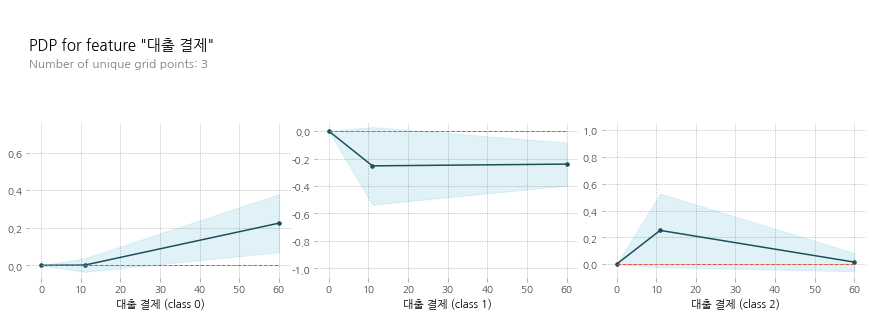

In [133]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp
pdp_goals = pdp.pdp_isolate(model=model1, dataset=train_X, model_features=train_X.columns, feature='대출 결제')

# plot it
pdp.pdp_plot(pdp_goals,ncols=3, feature_name='대출 결제',plot_params= {'font_family':'NanumGothic'})
plt.show()

- 우수등급일 수록 대출 결제 횟수가 많은 쪽에 분포해있는 것을 알 수 있다 
- 이것은 대출을 많이 한 사람일수록 신용도 측정에 유리하기 때문인 것으로 보인다

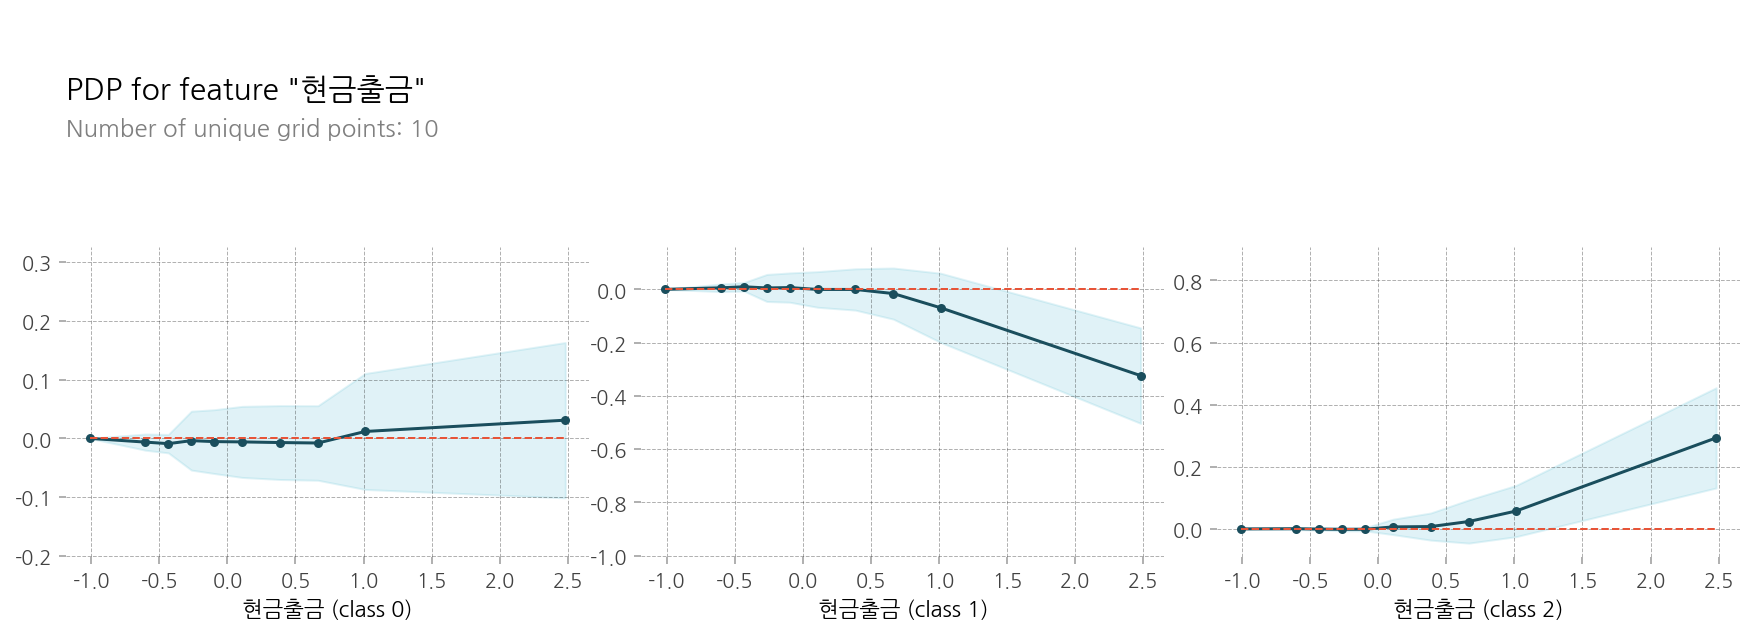

In [500]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp
pdp_goals = pdp.pdp_isolate(model=model1, dataset=train_X, model_features=train_X.columns, feature='현금출금')

# plot it
pdp.pdp_plot(pdp_goals,ncols=3, feature_name='현금출금',plot_params= {'font_family':'NanumGothic'})
plt.show()

- 위험 고객일 수록 현금 출금 횟수가 많은 것을 알 수 있다

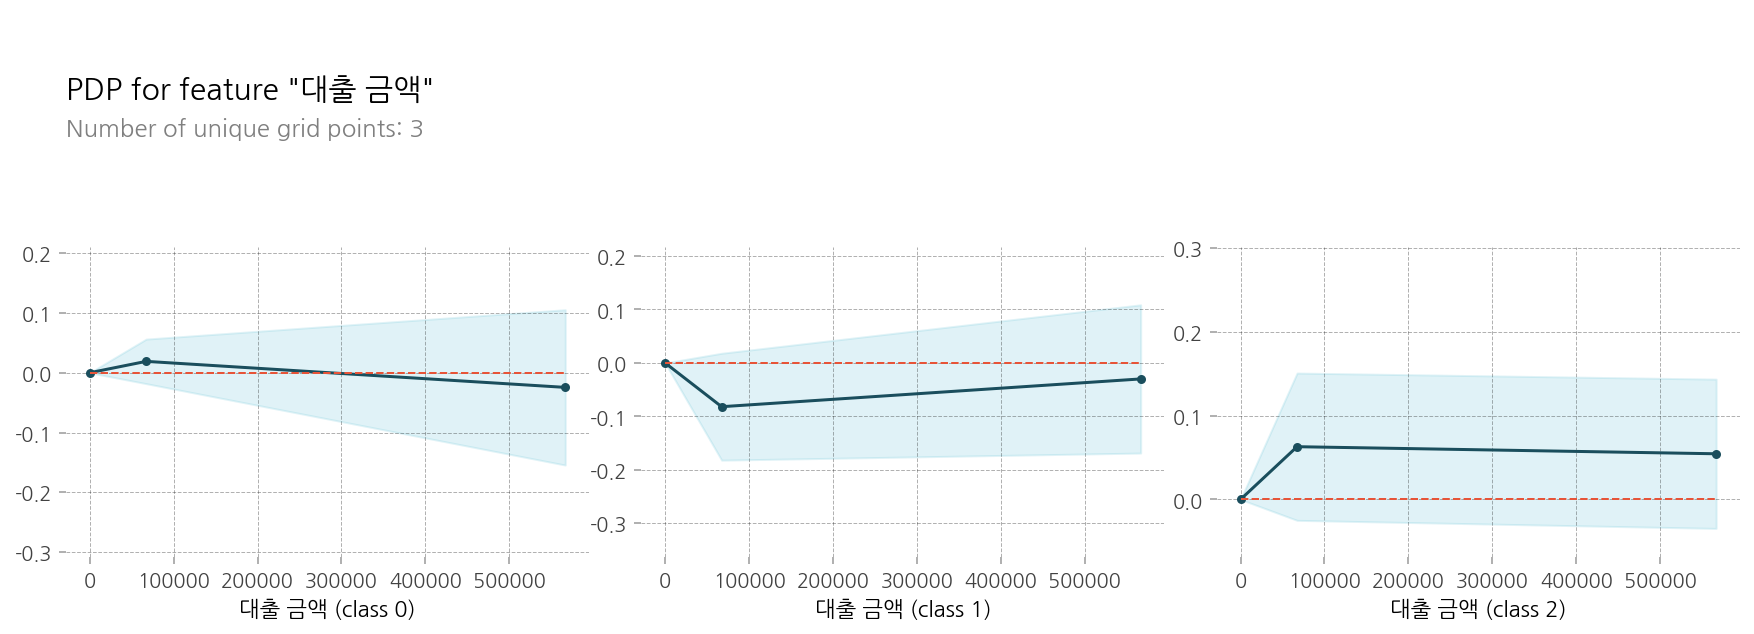

In [501]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp
pdp_goals = pdp.pdp_isolate(model=model1, dataset=train_X, model_features=train_X.columns, feature='대출 금액')

# plot it
pdp.pdp_plot(pdp_goals,ncols=3, feature_name='대출 금액',plot_params= {'font_family':'NanumGothic'})
plt.show()

- 위험 고객일수록 대출 금액이 큰 쪽에 분포한다
- 대출금액이 많은 고객일수록 더욱 세부적으로 신용을 심사할 필요가 있다

# PDP : 2개 FEATRUE

In [502]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
# 대출 결제 횟수, 현금인출 횟수 

features = [ '대출 결제', '현금출금']

interaction = pdp_interact(
    model=model1,
    dataset=train_X,
    model_features=train_X.columns, 
    features=features)


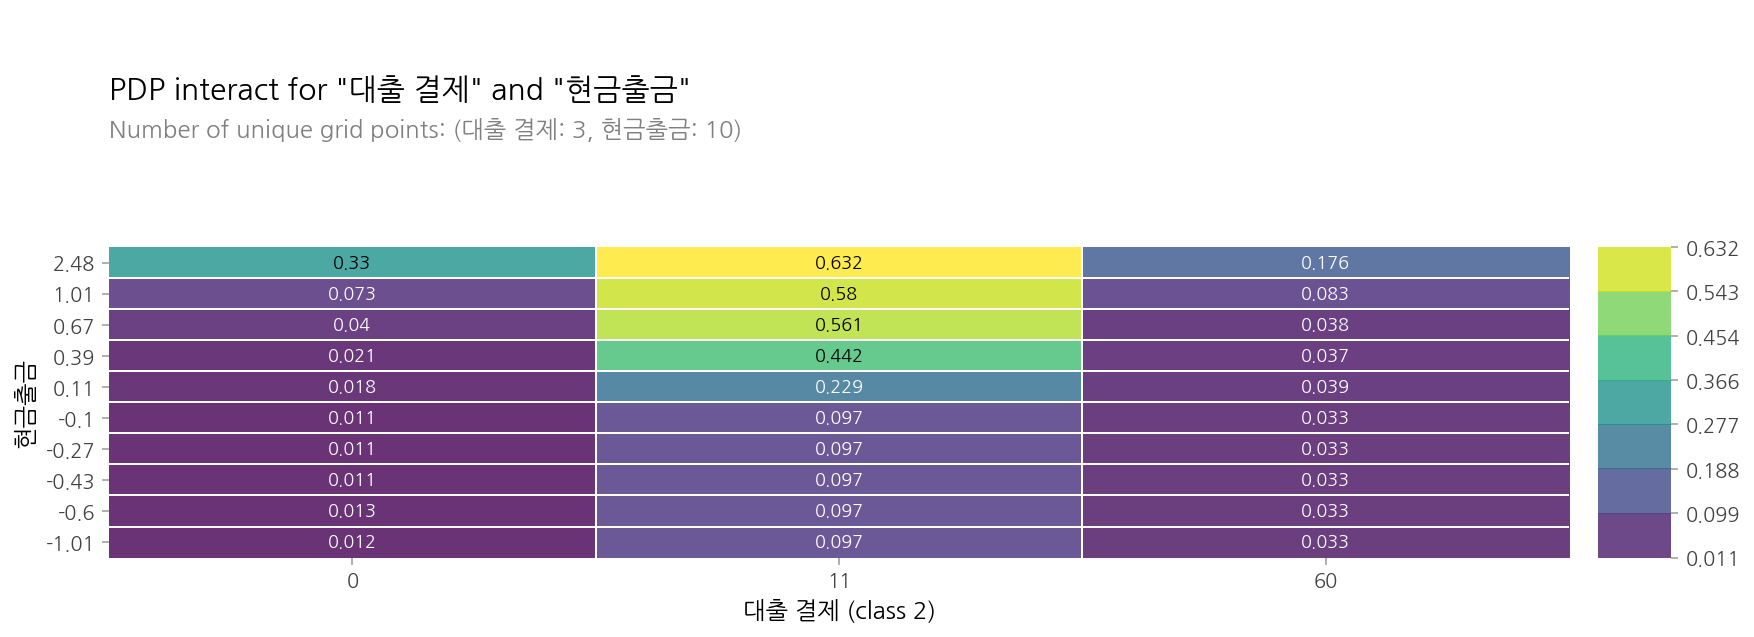

In [503]:
pdp_interact_plot(interaction,ncols=1, 
                  plot_type='grid',
                  figsize=(14,5),
                  feature_names=features,
                  plot_params= {'font_family':'NanumGothic'},
                  which_classes=[2]);

# 대출 결제 횟수가 중간정도이며 현금인출이 많을수록 위험고객일 확률이 크다는 것을 알 수 있습니다. 

# SHAP 시각화

In [ ]:
!pip install shap

## SHAP.force_plot 으로 타겟값에 영향을 주는 요소 파악 

In [505]:
row = train_X.iloc[0:2000]

In [524]:
shap_values[0]

array([[-2.57458488e-03, -1.52385448e-03, -2.55221898e-03, ...,
        -4.33054151e-04,  3.51207040e-05,  5.03882980e-05],
       [ 6.61359867e-04, -1.41760207e-02, -4.03034159e-02, ...,
         4.14972978e-02,  2.30099836e-04,  6.20180330e-05],
       [ 7.49569533e-03,  3.14903775e-02,  9.74787212e-02, ...,
         6.33166812e-03,  6.62042633e-03,  8.21670620e-03],
       ...,
       [ 3.94368796e-04, -3.29122616e-03, -2.31477066e-04, ...,
        -1.17355086e-03,  4.73502819e-05,  5.22923524e-05],
       [ 5.14452630e-04, -2.29503607e-03, -5.43537546e-03, ...,
         1.26401674e-04,  8.05281133e-05,  2.29179214e-04],
       [ 1.28993490e-04, -4.97318281e-03, -2.74034387e-03, ...,
         1.67397459e-04,  3.88484146e-04,  2.03858645e-04]])

### 빨간색 : 타겟 값에 +요인 , 파란색 : 타겟 값에 -요인

In [686]:
explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(test_X)



print(test_X.iloc[105,:])
print("target 값: ",test_y.iloc[105])
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], test_X.iloc[105,:], link="logit")


age_levels     3.000000
총 출금액         -0.491047
거래 횟수         -0.309645
대출 결제          0.000000
보험금 지급 횟수     15.000000
이자 지급 횟수      -0.500000
노령 연금          0.000000
타은행 출금         0.540000
타은행 입금         0.703704
현금입금          -0.363636
현금출금          -0.542169
신용카드 출금        0.000000
대출 금액          0.000000
FEMALE         0.000000
MALE           1.000000
Name: 953, dtype: float64
target 값:  2


## 여러 개의 값 예측 후 영향을 주는 요소 파악

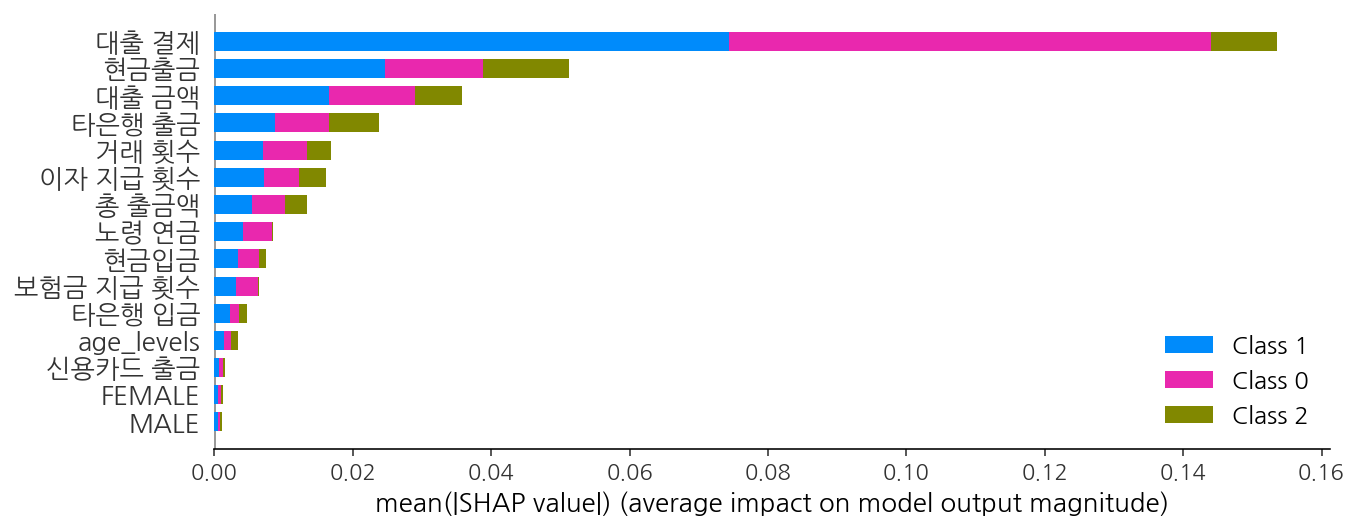

In [541]:
shap_values = explainer.shap_values(train_X.iloc[0:2000])
shap.summary_plot(shap_values, train_X.iloc[1000:2000], plot_size=(10,4))


# 그중  class1과 class0에 영향을 많이 미침 
# 개별 특성으로 등급에 미치는 영향을 평가하기에는 우수고객과 위험고객을 나누는 기준이 모호하므로
# 특성별 조합을 통해 파악 필요

# 추가적인 비지니스 인사이트 도출

In [542]:
import datetime

trans['date'] = pd.to_datetime(trans['date'],format='%y%m%d')

In [543]:
trans['year'] = trans['date'].dt.year
trans['month'] = trans['date'].dt.month
trans['day'] = trans['date'].dt.day

In [544]:
trans.head()

trans_id  account_id       date    type  amount  balance k_symbol  account  \
0    695247        2378 1993-01-01  PRIJEM   700.0    700.0      NaN      NaN   
1    171812         576 1993-01-01  PRIJEM   900.0    900.0      NaN      NaN   
2    207264         704 1993-01-01  PRIJEM  1000.0   1000.0      NaN      NaN   
3   1117247        3818 1993-01-01  PRIJEM   600.0    600.0      NaN      NaN   
4    579373        1972 1993-01-02  PRIJEM   400.0    400.0      NaN      NaN   

   minus     PREVOD NA UCET  PREVOD Z UCTU  VKLAD  VYBER  VYBER KARTOU  year  \
0      0  0               0              0      1      0             0  1993   
1      0  0               0              0      1      0             0  1993   
2      0  0               0              0      1      0             0  1993   
3      0  0               0              0      1      0             0  1993   
4      0  0               0              0      1      0             0  1993   

   month  day  
0      1    1  
1      1    1  
2      1    1  
3      1    1  
4      1    2

[Text(0.5, 0, 'day'), Text(0.5, 1.0, '일별 금융 거래량')]

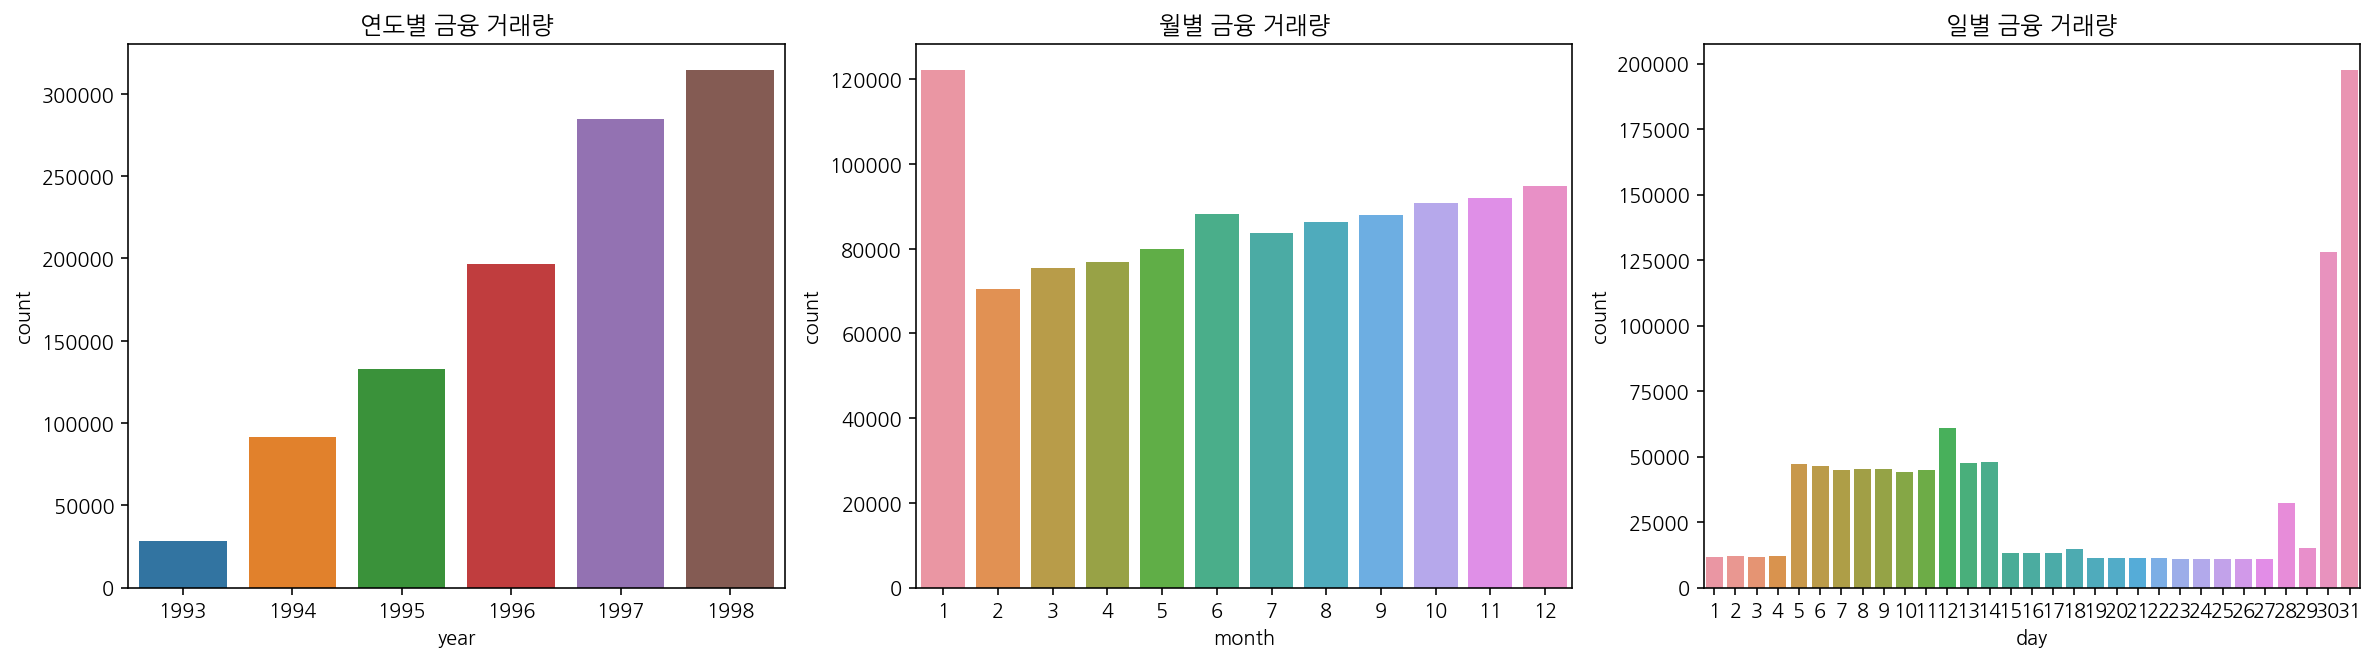

In [545]:
figure,(ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(20,5)

sns.countplot(x=trans['year'], ax=ax1)
sns.countplot(x=trans['month'], ax=ax2)
sns.countplot(x=trans['day'], ax=ax3)
ax1.set(xlabel='year', title="연도별 금융 거래량")
ax2.set(xlabel='month', title="월별 금융 거래량")
ax3.set(xlabel='day', title="일별 금융 거래량")

- 1998년에 금융 거래량이 가장 많다 => 경제활동이 활발해지고 있다 
- 1월에 금융 거래량이 가장 많다 => 새해가 되어 심리적 변화로 소비량이 많아지는 것으로 예상
- 30,31일(월말)에 거래량이 많은 것을 알 수 있다 

[Text(0.5, 0, 'day'), Text(0.5, 1.0, '일별 거래액')]

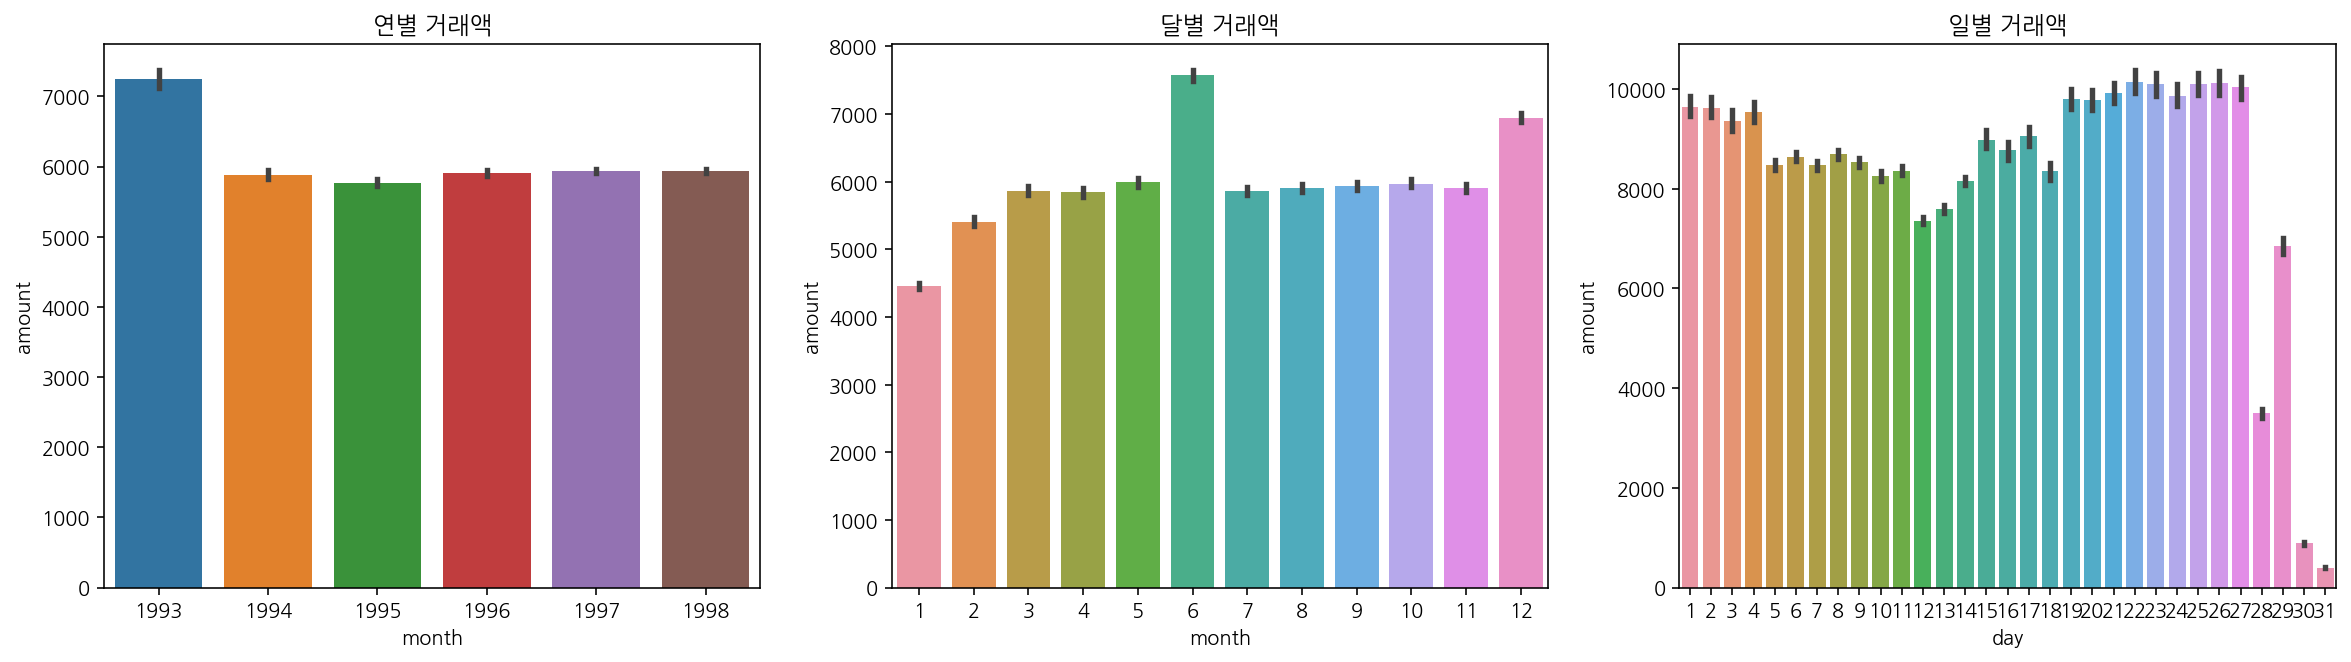

In [546]:
import matplotlib.pyplot as plt
figure,(ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(20,5)

sns.barplot(data=trans, x='year', y='amount', ax=ax1)
sns.barplot(data=trans, x='month', y='amount', ax=ax2)
sns.barplot(data=trans, x='day', y='amount', ax=ax3)s
ax1.set(xlabel='month', title="연별 거래액")
ax2.set(xlabel='month', title="달별 거래액")
ax3.set(xlabel='day', title="일별 거래액")

[Text(0.5, 0, 'day'), Text(0.5, 1.0, '일별 잔금액')]

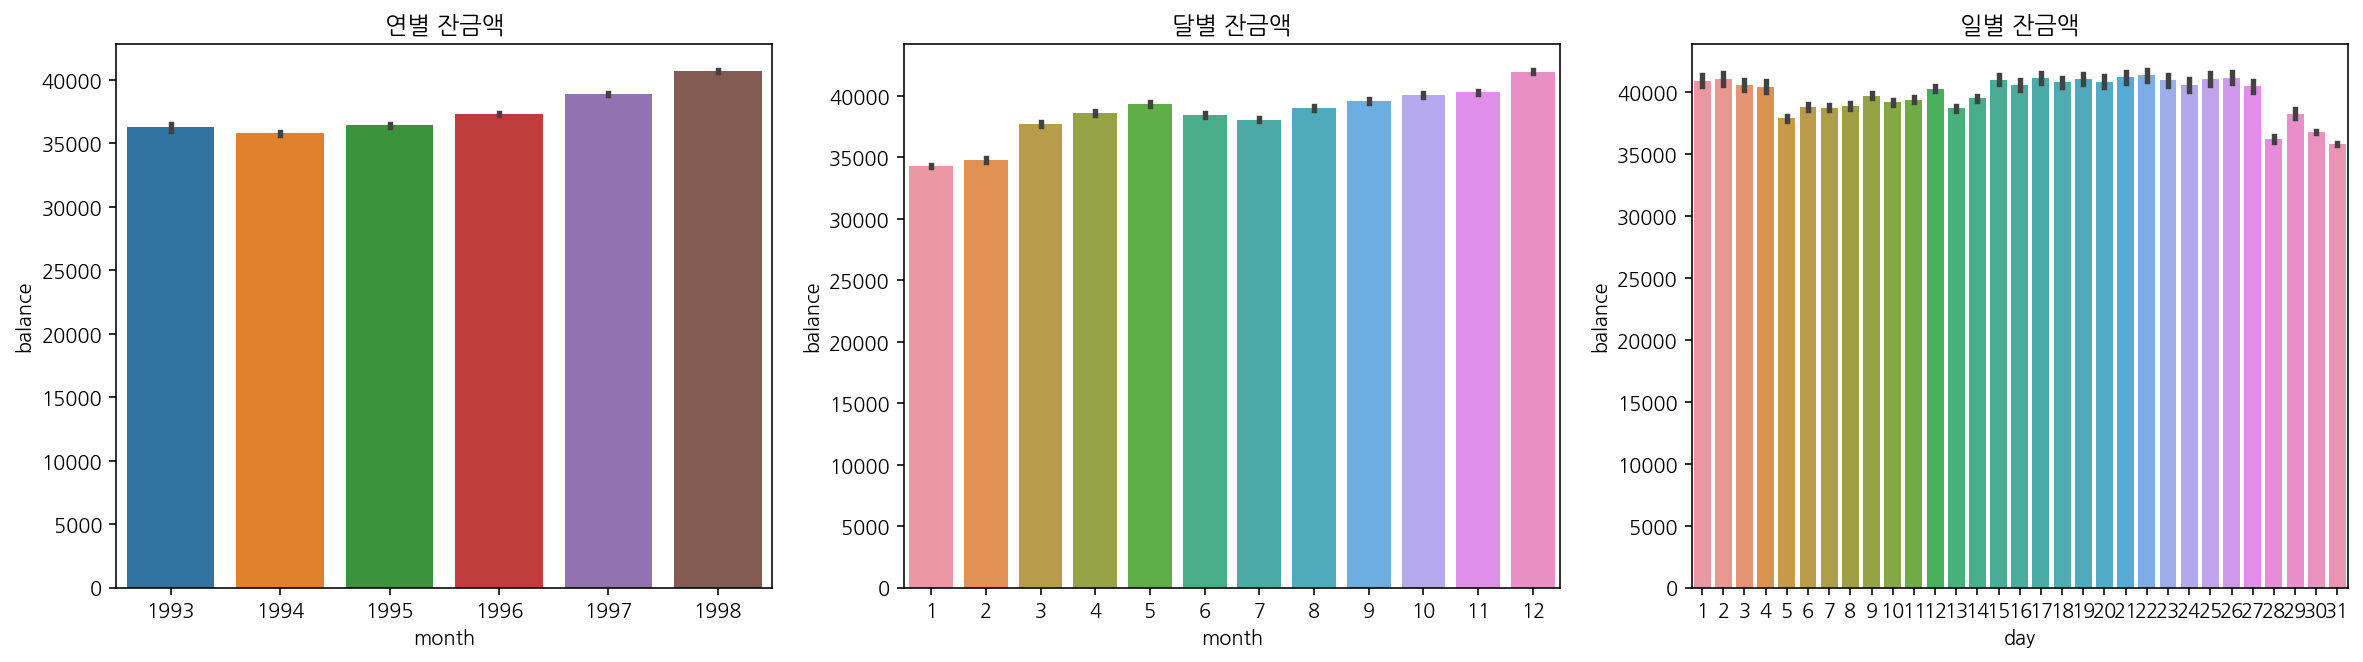

In [547]:
import matplotlib.pyplot as plt
figure,(ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(20,5)

sns.barplot(data=trans, x='year', y='balance', ax=ax1)
sns.barplot(data=trans, x='month', y='balance', ax=ax2)
sns.barplot(data=trans, x='day', y='balance', ax=ax3)
ax1.set(xlabel='month', title="연별 잔금액")
ax2.set(xlabel='month', title="달별 잔금액")
ax3.set(xlabel='day', title="일별 잔금액")

In [703]:
final.columns

Index(['age_levels', '총 입금액', '총 출금액', '마이너스 횟수', '거래 횟수', '현재 잔고', '마이너스 이자',
       '대출 결제', '보험금 지급 횟수', '이자 지급 횟수', '노령 연금', '타은행 출금', '타은행 입금', '현금입금',
       '현금출금', '신용카드 출금', '이용기간', '이용하지 않은 기간', '대출 금액', '대출 상태', 'FEMALE',
       'MALE'],
      dtype='object')

[Text(0.5, 0, '타은행 출금'), Text(0.5, 1.0, '타은행 출금에 따른 거래 횟수')]

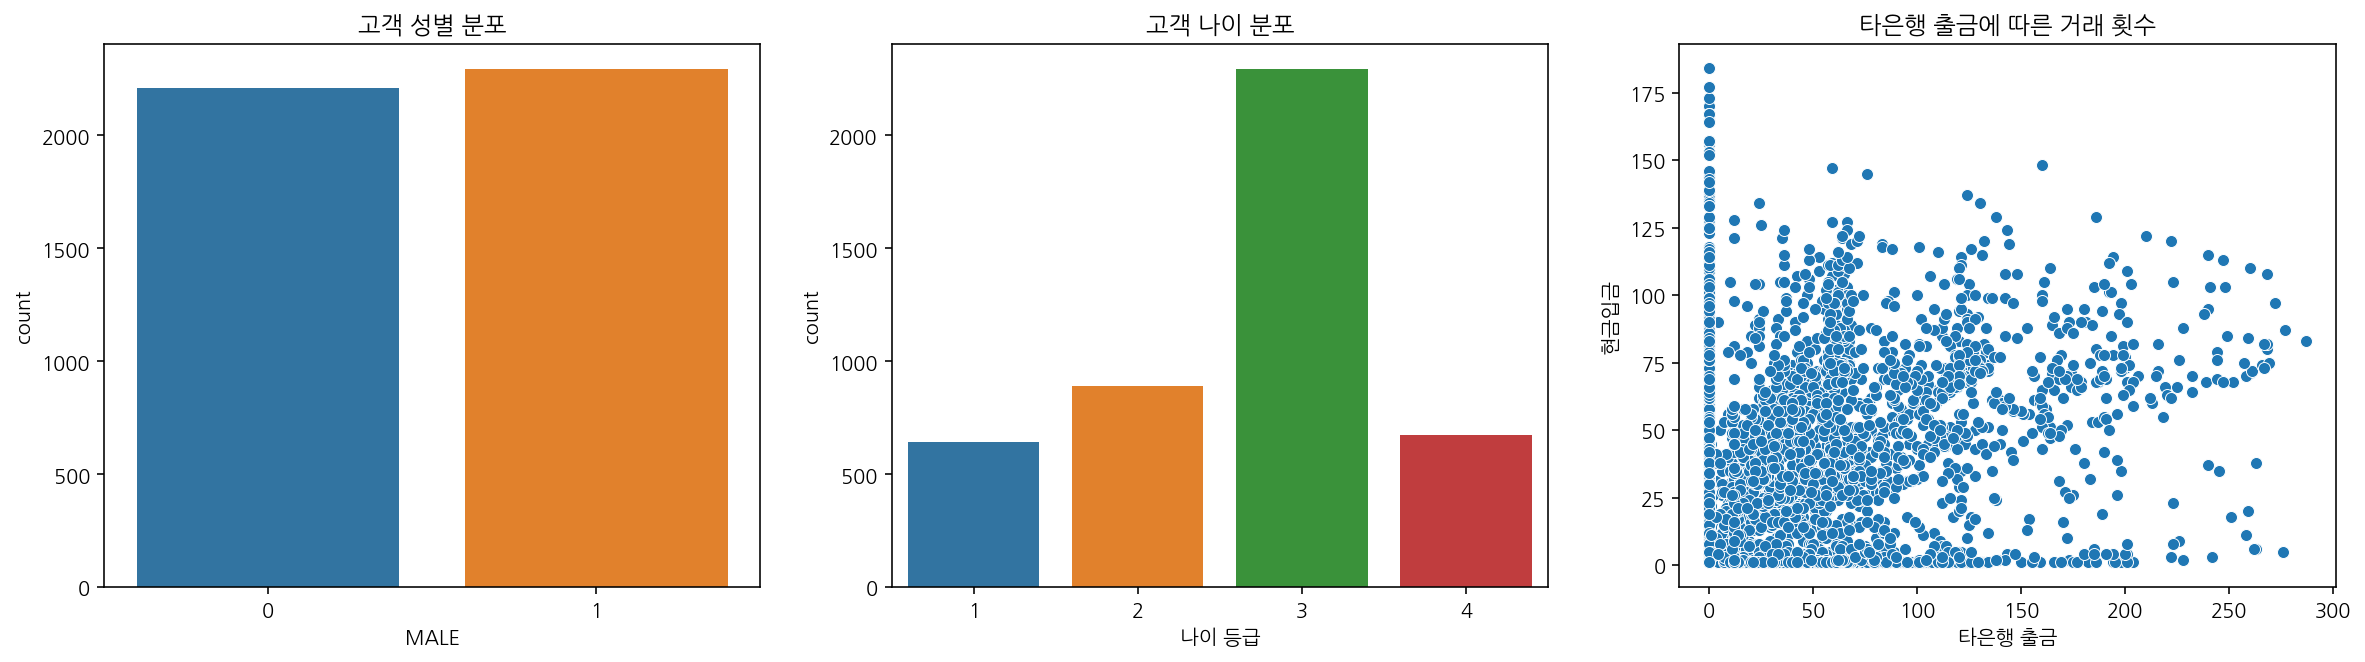

In [711]:
# 잔금(balance) 분포 
figure,(ax1,ax2,ax3)= plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(20,5)

sns.countplot(x=final['MALE'], ax=ax1)
sns.countplot(x=final['age_levels'],ax=ax2)
sns.scatterplot(data=final, x='타은행 출금', y='현금입금', ax=ax3)

ax1.set(xlabel='MALE', title="고객 성별 분포")
ax2.set(xlabel='나이 등급', title="고객 나이 분포")
ax3.set(xlabel='타은행 출금', title="타은행 출금에 따른 거래 횟수")


- middle aged 연령대의 고객이 가장 많다(40~50대)

In [676]:
trans['account_id'].value_counts()

8261    672
3834    663
96      659
2932    653
9307    644
       ... 
1563     12
758      12
727      11
315      11
182       9
Name: account_id, Length: 4500, dtype: int64

[Text(0, 0.5, '입금'), Text(0.5, 0, '출금'), Text(0.5, 1.0, '출금액 입금액 비교')]

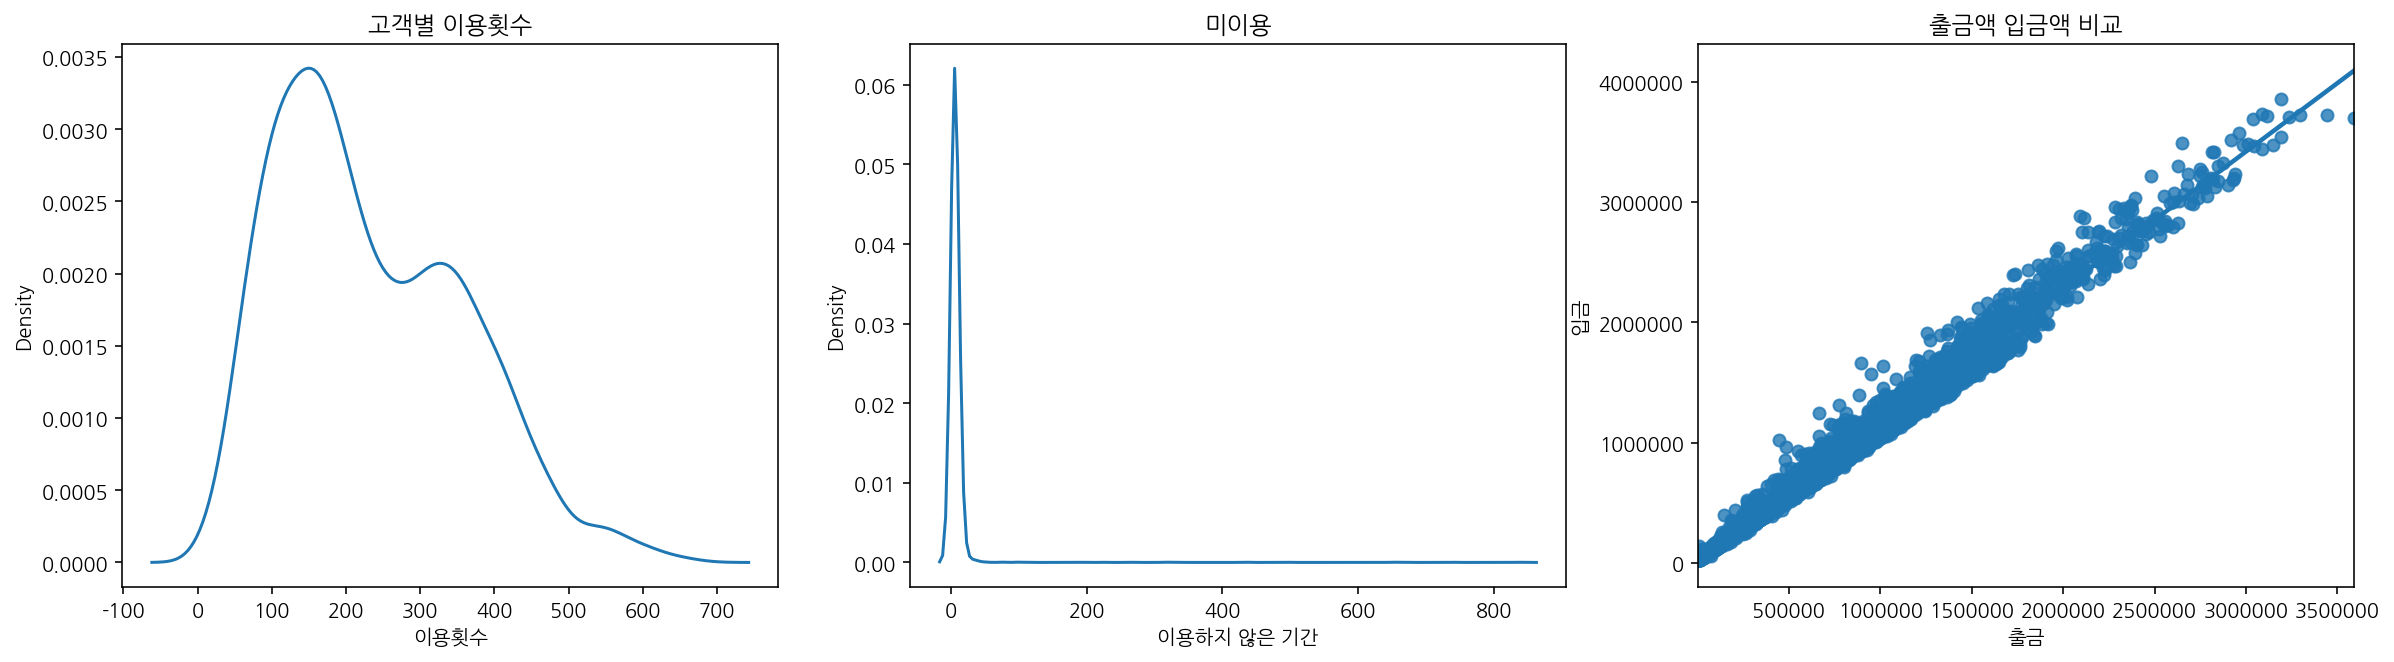

In [679]:
figure,(ax1,ax2,ax3)= plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(20,5)

sns.kdeplot(x=trans['account_id'].value_counts(), ax=ax1)
sns.kdeplot(final_copy['이용하지 않은 기간'],ax=ax2)
sns.regplot(data=final_copy,x='총 출금액',y='총 입금액', ax=ax3)

ax1.set(xlabel='이용횟수', title="고객별 이용횟수")
ax2.set(xlabel='이용하지 않은 기간', title="미이용")
ax3.set(xlabel='출금',ylabel='입금', title="출금액 입금액 비교")



- 100회 정도 거래한 고객이 가장 많음   
- 입금액과 출금액의 분포가 비슷하여 예금액은 비슷하게 유지
- 10일 정도 이용하지 않는 것이 평균적이며 그 이상 넘어갈 경우 휴먼 고객의 예방 조치 필요

In [682]:
trans2 = pd.read_csv("trans 수정.csv")
trans2.loc[trans2.type=='VYBER', 'type'] = 'VYDAJ'

[Text(0.5, 0, '금융 거래 detail'), Text(0.5, 1.0, '거래 detail별 총 금액')]

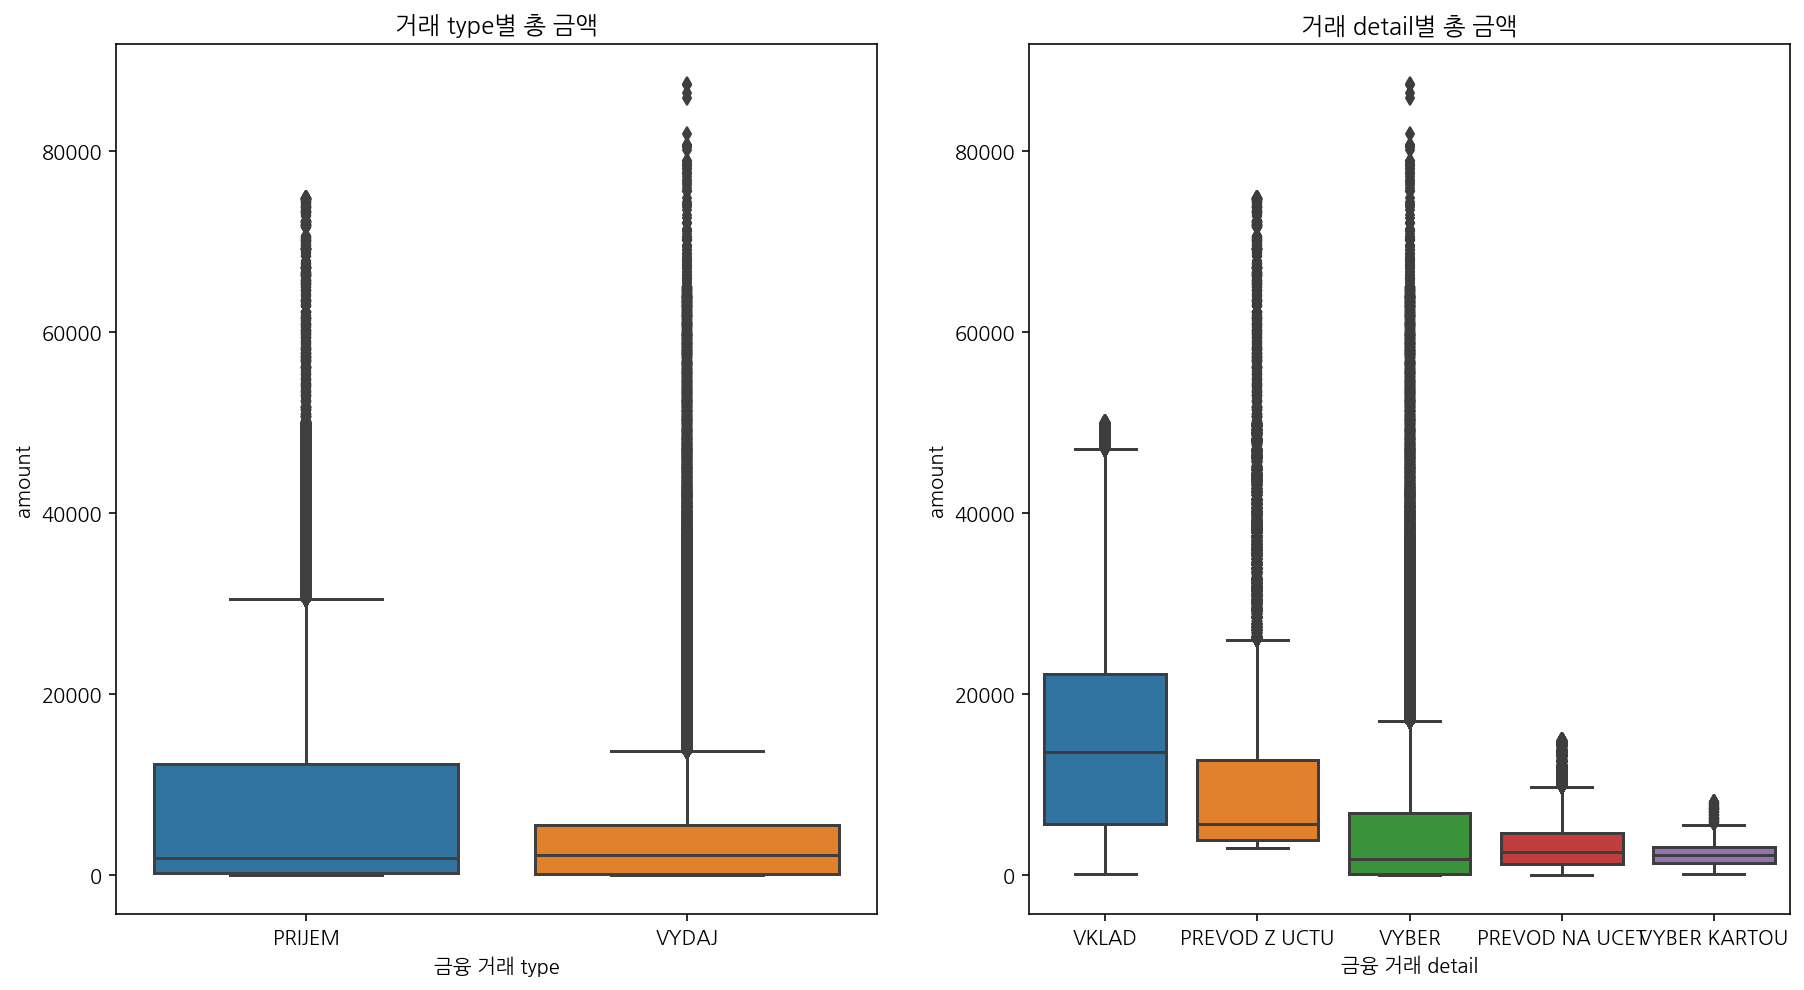

In [683]:
# 잔금(balance) 분포 
figure,(ax1,ax2)= plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(15,8)
sns.boxplot(data=trans2, x='type', y='amount', ax=ax1)
sns.boxplot(data=trans2, x='operation', y='amount', ax=ax2)

ax1.set(xlabel='금융 거래 type', title="거래 type별 총 금액")
ax2.set(xlabel='금융 거래 detail', title="거래 detail별 총 금액")

#  입금(PRIJEM), 출금(VYDAJ)
#  입금(PRIJEM) : 현금 입금(VKLAD), 타은행에서 입금(PREVOD Z UCTU)
#  출금(VYDAJ) : 현금 인출(VYBER), 타은행으로 송금(PREVOD NA UCET), 신용카드 인출(VYBER KARTOU)

- 입금(PRIJEM) 거래액 > 출금(VYDAJ) 거래액 
- 거래 detail에서 현금 입금(VKLAD) 거래액과 타은행에서 입금(PREVOD Z UCTU)이 가장 많음 (입금 거래가 많이 이루어짐)
 => 이에 맞춰 서비스 필요